In [0]:
import numpy as np
import pandas as pd
import re
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dropout, Dense, Conv2D, MaxPooling2D, Reshape, Lambda, Permute
from tensorflow.keras.backend import clear_session
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

def clean_text(tweet):
    #remove emoji
    emoji = re.compile("["
                        u'\U0001F600-\U0001F64F'  # emoticons
                        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
                        u'\U0001F680-\U0001F6FF'  # transport & map symbols
                        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
                        u'\U00002702-\U000027B0'
                        u'\U000024C2-\U0001F251'
                        "]+", flags=re.UNICODE)
    tweet = emoji.sub(r'', tweet)

    #remove punctuation
    punctuation = '''!\(\)-\[]\{};:'"\,<>./?@#$%^&*_~=+…''' + u'\u060C' + u'\u061B' + u'\u061F'
    for c in tweet:
        if c in punctuation:
            tweet = tweet.replace(c, '')

    #remove laughter
    laughter = re.compile(r'\b(ه|خ)\1{2,}\b')
    tweet = laughter.sub('', tweet)

    #remove nonsense
    nonsense = re.compile(r'\b(.)\1{2,}\b')
    tweet = nonsense.sub(r'', tweet)

    #normalize elongated words
    repeated_characters = re.compile(r'(.)\1{2,}')
    tweet = repeated_characters.sub(r'\1', tweet)

    return tweet

def ArabicToArabizi(tweet):
    arabicLetterList = ['ض','ص','ث','ق' ,'ف' ,
                                  'غ' ,'ع' ,'ه','خ' ,'ح' ,
                                  'ج' ,'د' ,'ش' ,'س' ,'ي' ,
                                  'ن','ت' ,'ا' ,'ل','ب',
                                  'ء','ئ','ط' ,'ك','م',
                                  'ؤ','ر','لا','ى','ة',
                                  'و','ز' ,'ظ','لأ','أ' ,
                             'إ', 'آ', ' ','ذ']
    
    arabiziMappingList = [['d'],['s'],['th'],[ '2'],['f'],
                      ['8'], [ '3'], ['h'], ['5'],['7'],
                      ['j'], ['d'], ['sh'], ['s'], ['y'],
                      ['n'], ['t'], ['a'], ['l'], ['b'],
                      ['2'],['2'], ['t'], ['k'], ['m'],
                      ['o2'], ['r'], ['la'], ['a'], ['a'],
                      ['o'], ['z'], ['z'], ['la2'], ['2'],
                      ['2'],['2'], [' '], ['z']]
    arabiziSentence =''
    arabicToArabiziMapping = dict()
    for x in range(0, len(arabicLetterList)):
        arabicToArabiziMapping[arabicLetterList[x]] = arabiziMappingList[x] 
    for x in range(0, len(tweet)):
        if tweet[x] in arabicToArabiziMapping.keys():
            if tweet[x] ==  'و':
                if x == 0:
                    arabiziSentence = arabiziSentence + 'w'
                elif tweet[x-1] ==' ':
                    arabiziSentence = arabiziSentence + 'w'
                else:
                    arabiziSentence = arabiziSentence + 'o'
            else :
                arabiziSentence = arabiziSentence + arabicToArabiziMapping[tweet[x]][random.randint(0,
                                                                 len(arabicToArabiziMapping[tweet[x]])-1)]
    arabiziSentence = arabiziSentence.replace( 'alozyr', 'alwazer')
    arabiziSentence = arabiziSentence.replace( 'hza', 'hayda')
    arabiziSentence = arabiziSentence.replace( 'hzh', 'hayde')
    arabiziSentence = arabiziSentence.replace( ' lao ', ' law ')
    arabiziSentence = arabiziSentence.replace( ' ho ', ' huwe ')
    arabiziSentence = arabiziSentence.replace( 'jbran ', ' gebran ')
    arabiziSentence = arabiziSentence.replace( 'qtr ', ' qatar ')
    arabiziSentence = arabiziSentence.replace( 'wlyd ', ' walid ')
    arabiziSentence = arabiziSentence.replace( 'al7ryry ', ' al hariri ')
    return arabiziSentence

In [0]:
url = 'https://raw.githubusercontent.com/Hala-Mulki/L-HSAB-First-Arabic-Levantine-HateSpeech-Dataset/master/Dataset/L-HSAB'
lhsab = pd.read_csv(url, sep='\t')

In [0]:
lhsab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5846 entries, 0 to 5845
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   5846 non-null   object
 1   Class   5846 non-null   object
dtypes: object(2)
memory usage: 91.5+ KB


In [0]:
lhsab['Class'].value_counts()

normal     3650
abusive    1728
hate        468
Name: Class, dtype: int64

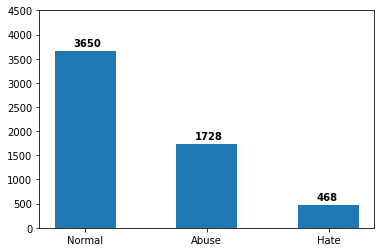

In [0]:
plt.bar(['Normal', 'Abuse', 'Hate'], lhsab['Class'].value_counts(), width=0.5)
plt.ylim(top=4500)
for index, value in enumerate(lhsab['Class'].value_counts()):
    plt.text(index-0.1, value+100, str(value), fontweight='bold')

In [0]:
newArabiziDataset = dict()
arabiziTweets = []
arabiziClasses = []
count = 0
for tweet in lhsab['Tweet']:
    newTweet = ArabicToArabizi(clean_text(tweet))
    arabiziTweets.append(newTweet)
    arabiziClasses.append(lhsab['Class'][count])
    count = count + 1

newArabiziDataset['Tweet'] = arabiziTweets
newArabiziDataset['Class'] = arabiziClasses
data = pd.DataFrame(newArabiziDataset, columns= ['Tweet', 'Class'])

MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 280

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True)
tokenizer.fit_on_texts(data['Tweet'].values)
VOCAB_SIZE = len(tokenizer.word_index) + 1
word_list = list(tokenizer.word_index.keys())

X = tokenizer.texts_to_sequences(data['Tweet'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

y = pd.get_dummies(data['Class'].values)
label_names = y.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y.values)

In [0]:
df = data.iloc[y_test.index]

---

**Naive Bayes**

In [0]:
count_vect = CountVectorizer(lowercase=True)
X_counts = count_vect.fit_transform(data['Tweet'])
tfidf = TfidfTransformer()
X_tfidf = tfidf.fit_transform(X_counts)
X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(X_tfidf, data['Class'], test_size=0.2, random_state=42, stratify=y)
sample_weights = compute_sample_weight('balanced', y_tfidf_train)
nb = MultinomialNB()
nb.fit(X_tfidf_train, y_tfidf_train, sample_weight=sample_weights)
y_pred = nb.predict(X_tfidf_test)

In [0]:
df['NB'] = y_pred

---

**Bi-LSTM**

In [0]:
lstm = load_model('/content/drive/My Drive/Neural Networks Project/bilstm_arabizi_cv2.h5')
y_pred = np.argmax(lstm.predict(X_test, batch_size=1), axis=1)

In [0]:
df['bilstm'] = [label_names[pred] for pred in y_pred]

---

**CNN-LSTM**

In [0]:
#Tuned
dropout_rate = 0.1
lstm_dropout = 0.7
lstm_units = 20
nb_filters = 64
filter_size = 3
L1=0.263
L2=0.15

#Not Tunable
EMBEDDING_DIM = 100
clear_session()
model = Sequential()
model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(Permute((2,1), input_shape = (MAX_SEQUENCE_LENGTH, EMBEDDING_DIM)))
model.add(Lambda(lambda t: t[..., None]))
model.add(Conv2D(nb_filters, (100,filter_size), input_shape=(EMBEDDING_DIM, MAX_SEQUENCE_LENGTH, 1), name = 'Conv'))
model.add(MaxPooling2D(pool_size= model.get_layer('Conv').output_shape[1:3]))
model.add(Dropout(dropout_rate))
model.add(Reshape((1, nb_filters)))
model.add(LSTM(lstm_units, return_sequences=False))
model.add(Dropout(lstm_dropout))
model.add(Dense(3, activation='softmax', kernel_regularizer = regularizers.l1_l2(l1= L1, l2= L2)))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.load_weights('/content/drive/My Drive/Neural Networks Project/CNN-lstm_arabizi.h5')

y_pred = np.argmax(model.predict(X_test, batch_size=1), axis=1)

In [0]:
df['cnn_lstm'] = [label_names[pred] for pred in y_pred]

---

**BERT**

In [0]:
bert_pred = pd.read_csv('/content/drive/My Drive/Neural Networks Project/ArabiziBERT_New.csv', names=['pred'])

In [0]:
df['bert'] = bert_pred['pred'].values

In [0]:
df.head()

,Tweet,Class,NB,bilstm,cnn_lstm,bert
1918,akyd msh fadya bdk tkby sm byn al3alm,normal,normal,normal,normal,normal
5802,zmn altb3ya walt3tylytjsd fy syasa gebran basyl,normal,normal,normal,normal,normal
4412,b2s zmn t2ym fyh 8ada 3yd gebran basyl,normal,normal,normal,normal,normal
1228,2olkm gebran basyl by2ra alt3ly2at ally btnzl...,normal,normal,normal,normal,normal
4058,ya 3m allh ya5dk,normal,abusive,normal,normal,normal


In [0]:
df.insert(0, 'Arabic', lhsab.iloc[df.index, 0].values)

In [0]:
df.to_csv('/content/drive/My Drive/Neural Networks Project/test_results.csv')